In [1]:
#comment out if not using colab
#from google.colab import files
#uploaded = files.upload()

In [2]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,LSTM,TimeDistributed,Dense,Flatten,Dropout,RepeatVector,GRU,Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [3]:
from distutils.version import LooseVersion

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.5.0-dev20201211
Default GPU Device: /device:GPU:0


In [4]:
filename='../datasets/pre_data_dl.csv'
data_dl=pd.read_csv(filename)
#pd.set_option('display.max_columns', None)
print(data_dl.head())
filename1='../datasets/pre_data_dl_aug1.csv'
filename2='../datasets/pre_data_dl_aug2.csv'
data_dl_aug1=pd.read_csv(filename1)
pd.set_option('display.max_columns', None)
print(data_dl_aug1.head())
data_dl_aug2=pd.read_csv(filename2)
print(data_dl_aug2.head())

   Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                        Combined Description Cleaned Assignment group  
0  login issue user manager name checked the name...            GRP_0  
1  outlook received from hello team my are not in...            GRP_0  
2    cannot log in to received from   cannot on best            GRP_0  
3                         unable to access tool page            GRP_0  
4                                              error            GRP_0  
   Unnamed: 0                       Combined Description Cleaned  \
0           0  login issue user manager name checked the name...   
1           1  outlook received from hello team my are not in...   
2           2  cannot log in to received from hi i cannot on ...   
3           3                         unable to access tool page   
4           4                            

In [5]:
adam=Adam()
sgd=SGD()
rmsprop=RMSprop()

In [6]:
X = (data_dl["Combined Description Cleaned"])
y= (data_dl['Assignment group'])

#categorical encoding y
y=pd.get_dummies(data_dl['Assignment group'])
  

In [7]:
#parameters
max_features=10000
emb_dim=300
batch_size=1024
epochs=10

In [8]:
#function for tokenizer
def dfTokenizer(df):
 tokenizer=Tokenizer(num_words=max_features,char_level=False)
 tokenizer.fit_on_texts(df)
 sequences=tokenizer.texts_to_sequences(df)
 return sequences,tokenizer
#tokenization
X,tokenizer = dfTokenizer(data_dl["Combined Description Cleaned"]) 
vocab_size=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size)

vocabulary size is:  3316


In [9]:
#function for padding
def pad(x, length=None):
 if length is None:
   length=max([len(sentence)  for sentence in x])
 return pad_sequences(x,maxlen=length,padding='post')
 
 #padding 
X=pad_sequences(X,padding='post')

In [10]:
#function for splitting the data
def split(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.2,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl
#split the data
X_train,X_test,y_train,y_test=split(X,y)


In [11]:
#configuring the callback
early_stopping =  EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    min_delta=0.01, 
    mode='max'
)

In [12]:
#function for plotting accuracy,loss
def plot(model,history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epochs = range(1, len(acc) + 1)
 plt.plot(epochs, acc, 'bo', label='Training acc')
 plt.plot(epochs, val_acc, 'b', label='Validation acc')
 plt.title(modelname + ' Training and validation accuracy')
 plt.legend()
 plt.figure()
 plt.plot(epochs, loss, 'bo', label='Training loss')
 plt.plot(epochs, val_loss, 'b', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
 plt.show()
 return 
inp_len=X.shape[1]
print(inp_len)

189


In [13]:
#Simple LSTM model
def LSTM_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(LSTM(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
 model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model
 

In [14]:
#customising the kerastuner function to include batch size and epochs
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
     kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 256, 512,step=256 )
     kwargs['epochs'] = trial.hyperparameters.Int('epochs', 5, 10,20)
     super(MyTuner, self).run_trial(trial, *args, **kwargs)

Trial 15 Complete [00h 00m 10s]
val_accuracy: 0.5721862316131592

Best val_accuracy So Far: 0.5987036228179932
Total elapsed time: 00h 02m 40s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/1/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.5987036228179932
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.5975250601768494
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.5910429954528809
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.5863288044929504
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.5851502418518066
None
Model: "sequential"
______________________________________________________

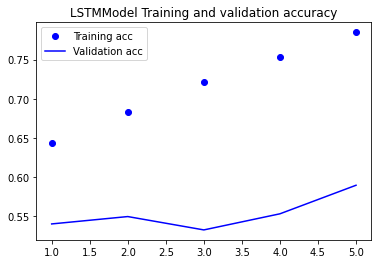

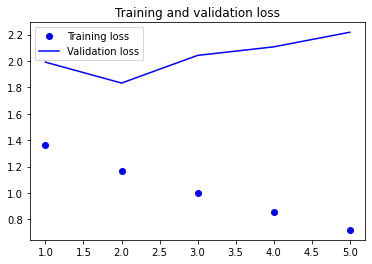

Accuracy of LSTM for unaugmented data is : 58.927518129348755
Validation Accuracy of LSTM for unagumented data is: 81.32370114326477
Mean loss of  Validation data of LSTM for unaugmented data is : 2.037966322898865
Mean loss of  Training data of LSTM for unaugmented data is : 1.0199706315994264


In [15]:
tuner =MyTuner(
    LSTM_model,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/1"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_LSTM = tuner.get_best_models()[0]
print("Hyperparameters for LSTM are",best_model_LSTM)


modelname="LSTMModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_LSTM.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_LSTM,history)

scores_LSTM =best_model_LSTM.evaluate(X_test, y_test, verbose=0)
scores_LSTM_val = best_model_LSTM.evaluate(X_train, y_train, verbose=0)
print("Accuracy of LSTM for unaugmented data is :", (scores_LSTM[1]*100))
print("Validation Accuracy of LSTM for unagumented data is:", (scores_LSTM_val[1]*100))
#print("Validation Accuracy of LSTM for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of LSTM for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of LSTM for unaugmented data is :",np.array(history.history['loss']).mean())

In [16]:
#Using GRU
def GRU_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(GRU(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
 model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model



Trial 15 Complete [00h 00m 09s]
val_accuracy: 0.5763111114501953

Best val_accuracy So Far: 0.601060688495636
Total elapsed time: 00h 02m 33s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/2/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.601060688495636
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.593989372253418
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.5934001207351685
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.5869181156158447
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.5839717388153076
None
Model: "sequential"
__________________________________________________

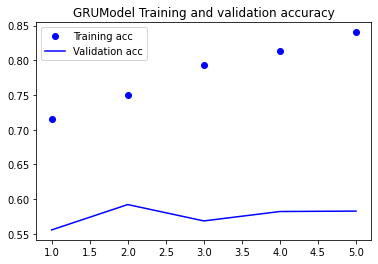

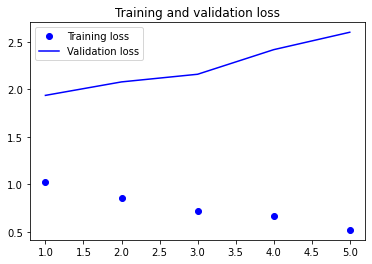

Accuracy of GRU for unaugmented data is : 58.27931761741638
Validation Accuracy of GRU for unagumented data is: 86.86615824699402
Mean loss of  Validation data of GRU for unaugmented data is : 2.237177324295044
Mean loss of  Training data of GRU for unaugmented data is : 0.757444190979004


In [17]:
tuner =MyTuner(
    GRU_model,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/2"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_GRU = tuner.get_best_models()[0]
print("Hyperparameters for GRU are",best_model_GRU)


modelname="GRUModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_GRU.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_GRU,history)

scores_GRU =best_model_GRU.evaluate(X_test, y_test, verbose=0)
scores_GRU_val = best_model_GRU.evaluate(X_train, y_train, verbose=0)
print("Accuracy of GRU for unaugmented data is :", (scores_GRU[1]*100))
print("Validation Accuracy of GRU for unagumented data is:", (scores_GRU_val[1]*100))
#print("Validation Accuracy of GRU for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of GRU for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of GRU for unaugmented data is :",np.array(history.history['loss']).mean())


In [18]:
#Using bidirectional LSTM

def BILSTM_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(Bidirectional(LSTM(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
 model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model



Trial 15 Complete [00h 00m 16s]
val_accuracy: 0.5792574882507324

Best val_accuracy So Far: 0.5904537439346313
Total elapsed time: 00h 04m 20s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/3/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.5904537439346313
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.5798467993736267
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.5792574882507324
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.5780789852142334
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.5774896740913391
None
Model: "sequential"
___________________________________________________________

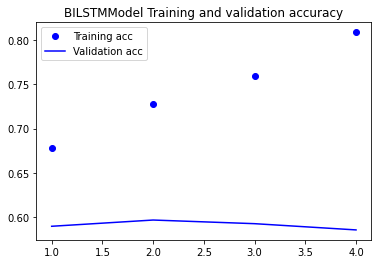

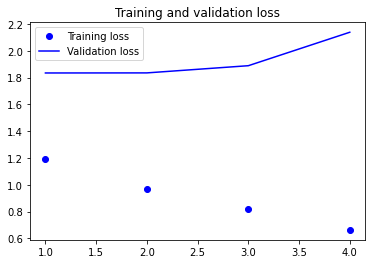

Accuracy of BILSTM for unaugmented data is : 58.515024185180664
Validation Accuracy of BILSTM for unagumented data is: 84.94988083839417
Mean loss of  Validation data of BILSTM for unaugmented data is : 1.9242857992649078
Mean loss of  Training data of BILSTM for unaugmented data is : 0.9125666618347168


In [19]:
tuner =MyTuner(
    BILSTM_model,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/3"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_BILSTM = tuner.get_best_models()[0]
print("Hyperparameters for BILSTM are",best_model_BILSTM)


modelname="BILSTMModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BILSTM.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_BILSTM,history)

scores_BILSTM =best_model_BILSTM.evaluate(X_test, y_test, verbose=0)
scores_BILSTM_val = best_model_BILSTM.evaluate(X_train, y_train, verbose=0)
print("Accuracy of BILSTM for unaugmented data is :", (scores_BILSTM[1]*100))
print("Validation Accuracy of BILSTM for unagumented data is:", (scores_BILSTM_val[1]*100))
#print("Validation Accuracy of BILSTM for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BILSTM for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of BILSTM for unaugmented data is :",np.array(history.history['loss']).mean())


In [20]:
#Using bidirectional GRU
def BIGRU_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(Bidirectional(GRU(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
 model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model



Trial 15 Complete [00h 00m 14s]
val_accuracy: 0.5945786833763123

Best val_accuracy So Far: 0.5945786833763123
Total elapsed time: 00h 03m 47s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/4/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.5945786833763123
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.5898644924163818
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.5880966186523438
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.5863288044929504
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.5851502418518066
None
Model: "sequential"
___________________________________________

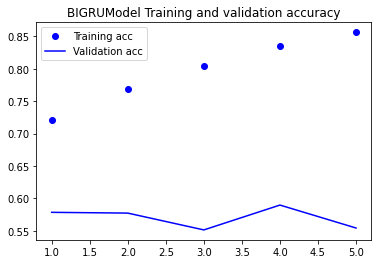

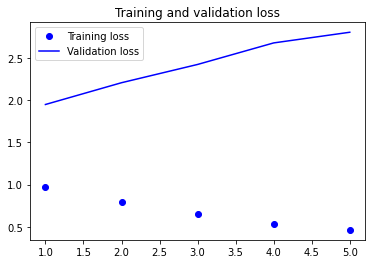

Accuracy of BIGRU for unaugmented data is : 55.45079708099365
Validation Accuracy of BIGRU for unagumented data is: 87.48525977134705
Mean loss of  Validation data of BIGRU for unaugmented data is : 2.4128216981887816
Mean loss of  Training data of BIGRU for unaugmented data is : 0.6832655847072602


In [21]:
tuner =MyTuner(
    BIGRU_model,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/4"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_BIGRU = tuner.get_best_models()[0]
print("Hyperparameters for BIGRU are",best_model_BIGRU)


modelname="BIGRUModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BIGRU.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_BIGRU,history)

scores_BIGRU =best_model_BIGRU.evaluate(X_test, y_test, verbose=0)
scores_BIGRU_val = best_model_BIGRU.evaluate(X_train, y_train, verbose=0)
print("Accuracy of BIGRU for unaugmented data is :", (scores_BIGRU[1]*100))
print("Validation Accuracy of BIGRU for unagumented data is:", (scores_BIGRU_val[1]*100))
#print("Validation Accuracy of BIGRU for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BIGRU for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of BIGRU for unaugmented data is :",np.array(history.history['loss']).mean())


In [22]:
X_aug1 = (data_dl_aug1["Combined Description Cleaned"])
y_aug1= (data_dl_aug1['Assignment group'])

#categorical encoding y
y_aug1=pd.get_dummies(data_dl_aug2['Assignment group'])


X_aug2 = (data_dl_aug2["Combined Description Cleaned"])
y_aug2= (data_dl_aug2['Assignment group'])

#categorical encoding y
y_aug2=pd.get_dummies(data_dl_aug2['Assignment group'])
  

In [23]:
#tokenization
X_aug1,tokenizer = dfTokenizer(data_dl_aug1["Combined Description Cleaned"]) 
vocab_size_aug1=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug1)

X_aug2,tokenizer = dfTokenizer(data_dl_aug2["Combined Description Cleaned"]) 
vocab_size_aug2=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug2)

vocabulary size is:  3956
vocabulary size is:  4424


In [24]:
#padding
X_aug1=pad_sequences(X_aug1,padding='post')
X_aug2=pad_sequences(X_aug2,padding='post')
y_aug1=y_aug1[0:17586]

In [25]:
#split the data.Only augmented data is split using stratify
def split_stratify(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl

X_train_aug1,X_test_aug1,y_train_aug1,y_test_aug1=split_stratify(X_aug1,y_aug1)
X_train_aug2,X_test_aug2,y_train_aug2,y_test_aug2=split_stratify(X_aug2,y_aug2)


inp_len1=X_aug1.shape[1]
print(inp_len1)

191


In [26]:
#Simple LSTM model1
def LSTM_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(LSTM(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
 model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model



#Using GRU
def GRU_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(GRU(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
 model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model


 #Using bidirectional LSTM

def BILSTM_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(Bidirectional(LSTM(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
 model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model


#Using bidirectional GRU
def BIGRU_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(Bidirectional(GRU(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
 model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model


Trial 15 Complete [00h 00m 18s]
val_accuracy: 0.721432626247406

Best val_accuracy So Far: 0.7819783687591553
Total elapsed time: 00h 04m 48s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/5/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.7819783687591553
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.721432626247406
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.7148948311805725
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
Score: 0.7146105766296387
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.7134735584259033
None
Model: "sequential"
_________________________________________________________________
Layer (typ

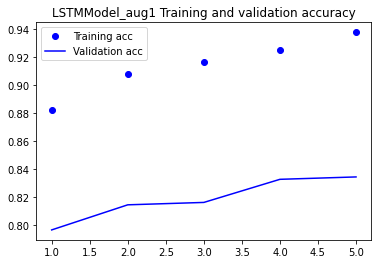

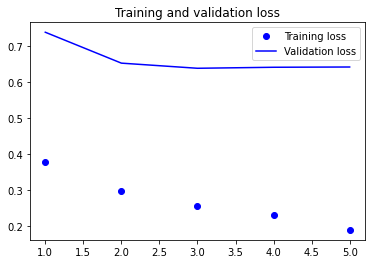

Accuracy of LSTM for level1 augmented data is : 83.45651030540466
Validation Accuracy of LSTM for level1 augmented data is: 94.89622116088867
Mean loss of  Validation data of LSTM for level1 augmented data is : 0.662816834449768
Mean loss of  training data of LSTM for level1 augmented data is : 0.2694961458444595


In [27]:
tuner =MyTuner(
    LSTM_model1,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/5"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_LSTM = tuner.get_best_models()[0]
print("Hyperparameters for LSTM are",best_model_LSTM)


modelname="LSTMModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_LSTM.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_LSTM,history)

scores_LSTM_aug1 =best_model_LSTM.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_LSTM_val_aug1 = best_model_LSTM.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of LSTM for level1 augmented data is :", (scores_LSTM_aug1[1]*100))
print("Validation Accuracy of LSTM for level1 augmented data is:", (scores_LSTM_val_aug1[1]*100))
#print("Validation Accuracy of LSTM for level1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of LSTM for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of LSTM for level1 augmented data is :",np.array(history.history['loss']).mean())

Trial 15 Complete [00h 00m 17s]
val_accuracy: 0.7640705108642578

Best val_accuracy So Far: 0.8192154765129089
Total elapsed time: 00h 04m 47s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/6/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.8192154765129089
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.7794201374053955
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.7745878100395203
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.7708925604820251
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.7706083059310913
None
Model: "sequential"
___________________________________________________________

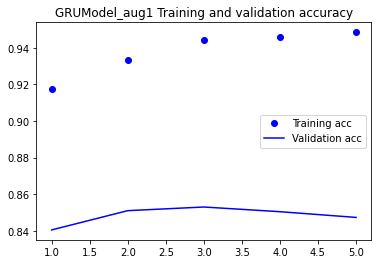

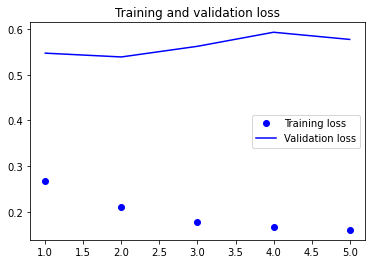

Accuracy of GRU for level1 augmented data is : 84.73564386367798
Validation Accuracy of GRU for level1 augmented data is: 95.79187035560608
Mean loss of  Validation data of GRU for level1 augmented data is : 0.5636784076690674
Mean loss of  training data of GRU for level1 augmented data is : 0.19667491912841797


In [28]:
tuner =MyTuner(
    GRU_model1,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/6"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_GRU = tuner.get_best_models()[0]
print("Hyperparameters for GRU are",best_model_GRU)


modelname="GRUModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_GRU.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_GRU,history)

scores_GRU_aug1 =best_model_GRU.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_GRU_val_aug1 = best_model_GRU.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of GRU for level1 augmented data is :", (scores_GRU_aug1[1]*100))
print("Validation Accuracy of GRU for level1 augmented data is:", (scores_GRU_val_aug1[1]*100))
#print("Validation Accuracy of GRU for level1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of GRU for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of GRU for level1 augmented data is :",np.array(history.history['loss']).mean())

Trial 15 Complete [00h 00m 31s]
val_accuracy: 0.7626492381095886

Best val_accuracy So Far: 0.802444577217102
Total elapsed time: 00h 07m 55s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/7/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.802444577217102
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.7754405736923218
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.7734508514404297
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.7714610695838928
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.771176815032959
None
Model: "sequential"
__________________________________________________

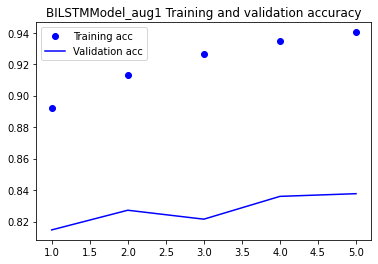

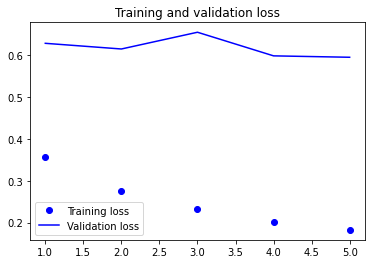

Accuracy of BILSTM for level1 augmented data is : 83.76918435096741
Validation Accuracy of BILSTM for level1 augmented  data is: 94.96729969978333
Mean loss of  Validation data of BILSTM for level1 augmented data is : 0.6182543992996216
Mean loss of  training data of BILSTM for level1 augmented data is : 0.24896386563777922


In [29]:
tuner =MyTuner(
    BILSTM_model1,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/7"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_BILSTM = tuner.get_best_models()[0]
print("Hyperparameters for BILSTM are",best_model_BILSTM)


modelname="BILSTMModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BILSTM.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_BILSTM,history)

scores_BILSTM_aug1 =best_model_BILSTM.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_BILSTM_val_aug1 = best_model_BILSTM.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of BILSTM for level1 augmented data is :", (scores_BILSTM_aug1[1]*100))
print("Validation Accuracy of BILSTM for level1 augmented  data is:", (scores_BILSTM_val_aug1[1]*100))
#print("Validation Accuracy of BILSTM forlevel1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BILSTM for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BILSTM for level1 augmented data is :",np.array(history.history['loss']).mean())


Trial 15 Complete [00h 00m 26s]
val_accuracy: 0.762080729007721

Best val_accuracy So Far: 0.8385446071624756
Total elapsed time: 00h 07m 04s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/8/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.8385446071624756
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.7913587093353271
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
Score: 0.7907902002334595
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.7907902002334595
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.7882319688796997
None
Model: "sequential"
_________________________________________________________________
Layer (typ

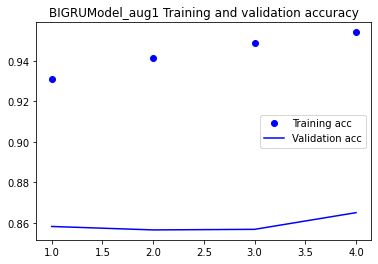

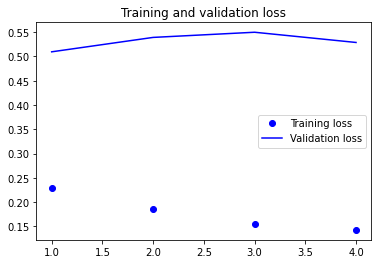

Accuracy of BIGRU for level1 augmented data is : 86.49801015853882
Validation Accuracy of BIGRU for level1 augmented data is: 96.20414972305298
Mean loss of  Validation data of BIGRU for level1 augmented data is : 0.5318908840417862
Mean loss of  training data of BIGRU for level1 augmented data is : 0.17793748527765274


In [30]:
tuner =MyTuner(
    BIGRU_model1,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/8"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_BIGRU = tuner.get_best_models()[0]
print("Hyperparameters for BIGRU are",best_model_BIGRU)


modelname="BIGRUModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BIGRU.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_BIGRU,history)

scores_BIGRU_aug1 =best_model_BIGRU.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_BIGRU_val_aug1 = best_model_BIGRU.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of BIGRU for level1 augmented data is :", (scores_BIGRU_aug1[1]*100))
print("Validation Accuracy of BIGRU for level1 augmented data is:", (scores_BIGRU_val_aug1[1]*100))
#print("Validation Accuracy of BIGRU for level1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BIGRU for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BIGRU for level1 augmented data is :",np.array(history.history['loss']).mean())


Trial 15 Complete [00h 00m 29s]
val_accuracy: 0.8328262567520142

Best val_accuracy So Far: 0.8824659585952759
Total elapsed time: 00h 08m 02s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/9/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.8824659585952759
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.8792634010314941
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.8768615126609802
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.8731785416603088
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.8664531707763672
None
Model: "sequential"
______________________________________________________

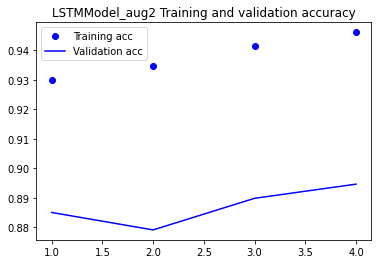

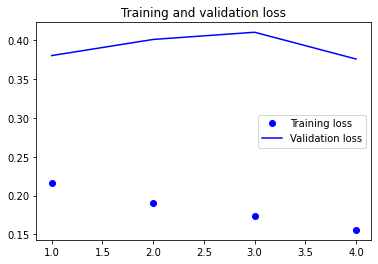

Accuracy of LSTM for level2 augmented data is : 89.46357369422913
Validation Accuracy of LSTM for level2 augmented data is: 95.5797553062439
Mean loss of  Validation data of LSTM for level2 augmented data is : 0.3920552432537079
Mean loss of  training data of LSTM for level2 augmented data is : 0.18390267714858055


In [31]:
tuner =MyTuner(
    LSTM_model1,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/9"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_LSTM = tuner.get_best_models()[0]
print("Hyperparameters for LSTM are",best_model_LSTM)


modelname="LSTMModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_LSTM.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_LSTM,history)

scores_LSTM_aug2 =best_model_LSTM.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_LSTM_val_aug2 = best_model_LSTM.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of LSTM for level2 augmented data is :", (scores_LSTM_aug2[1]*100))
print("Validation Accuracy of LSTM for level2 augmented data is:", (scores_LSTM_val_aug2[1]*100))
#print("Validation Accuracy of LSTM for level2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of LSTM for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of LSTM for level2 augmented data is :",np.array(history.history['loss']).mean())

Trial 15 Complete [00h 00m 27s]
val_accuracy: 0.8438751101493835

Best val_accuracy So Far: 0.9068054556846619
Total elapsed time: 00h 07m 32s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/10/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.9068054556846619
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.9034427404403687
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.8981585502624512
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.8970376253128052
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 512
epochs: 5
optimizer: adam
Score: 0.8941553235054016
None
Model: "sequential"
_________________________________________________________

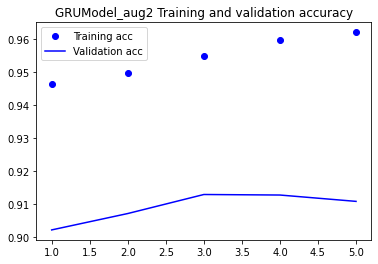

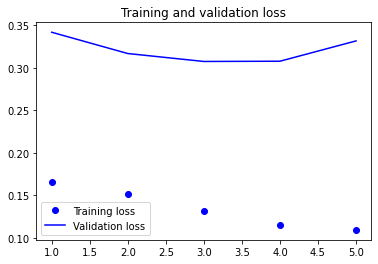

Accuracy of GRU for level2 augmented data is : 91.08086228370667
Validation Accuracy of GRU for level2 augmented data is: 96.77690863609314
Mean loss of  Validation data of GRU for level2 augmented data is : 0.3209525287151337
Mean loss of  training data of GRU for level2 augmented data is : 0.1344526320695877


In [32]:
tuner =MyTuner(
    GRU_model1,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/10"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_GRU = tuner.get_best_models()[0]
print("Hyperparameters for GRU are",best_model_GRU)


modelname="GRUModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_GRU.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_GRU,history)

scores_GRU_aug2 =best_model_GRU.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_GRU_val_aug2 = best_model_GRU.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of GRU for level2 augmented data is :", (scores_GRU_aug2[1]*100))
print("Validation Accuracy of GRU for level2 augmented data is:", (scores_GRU_val_aug2[1]*100))
#print("Validation Accuracy of GRU for level2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of GRU for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of GRU for level2 augmented data is :",np.array(history.history['loss']).mean())

Trial 15 Complete [00h 00m 54s]
val_accuracy: 0.8883907198905945

Best val_accuracy So Far: 0.8962370157241821
Total elapsed time: 00h 13m 41s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/11/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.8962370157241821
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.8883907198905945
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.8872697949409485
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: adam
Score: 0.8859887719154358
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.882786214351654
None
Model: "sequential"
______________________________________________

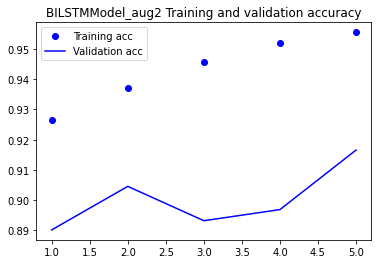

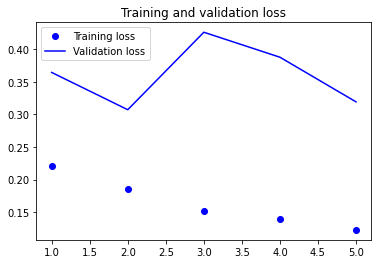

Accuracy of BILSTM for level2 augmented data is : 91.65732860565186
Validation Accuracy of BILSTM for level2 augmented  data is: 96.06822729110718
Mean loss of  Validation data of BILSTM for level2 augmented data is : 0.3611151397228241
Mean loss of  training data of BILSTM for level2 augmented data is : 0.1640914961695671


In [33]:
tuner =MyTuner(
    BILSTM_model1,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/11"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_BILSTM = tuner.get_best_models()[0]
print("Hyperparameters for BILSTM are",best_model_BILSTM)


modelname="BILSTMModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BILSTM.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_BILSTM,history)

scores_BILSTM_aug2 =best_model_BILSTM.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_BILSTM_val_aug2 = best_model_BILSTM.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of BILSTM for level2 augmented data is :", (scores_BILSTM_aug2[1]*100))
print("Validation Accuracy of BILSTM for level2 augmented  data is:", (scores_BILSTM_val_aug2[1]*100))
#print("Validation Accuracy of BILSTM forlevel2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BILSTM for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BILSTM for level2 augmented data is :",np.array(history.history['loss']).mean())

Trial 15 Complete [00h 00m 49s]
val_accuracy: 0.9084067344665527

Best val_accuracy So Far: 0.9168935418128967
Total elapsed time: 00h 12m 28s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:/Hyperparameter/12/untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.9168935418128967
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.9135308265686035
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.9108086228370667
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.9104883670806885
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 256
epochs: 5
optimizer: rmsprop
Score: 0.9100080132484436
None
Model: "sequential"
___________________________________________

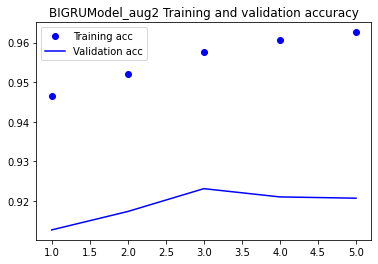

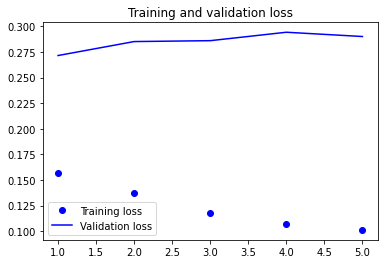

Accuracy of BIGRU for level2 augmented data is : 92.07366108894348
Validation Accuracy of BIGRU for level2 augmented data is: 96.97309136390686
Mean loss of  Validation data of BIGRU for level2 augmented data is : 0.28544187545776367
Mean loss of  training data of BIGRU for level2 augmented data is : 0.12415355145931244


In [34]:
tuner =MyTuner(
    BIGRU_model1,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/12"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_BIGRU = tuner.get_best_models()[0]
print("Hyperparameters for BIGRU are",best_model_BIGRU)


modelname="BIGRUModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BIGRU.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_BIGRU,history)

scores_BIGRU_aug2 =best_model_BIGRU.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_BIGRU_val_aug2 = best_model_BIGRU.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of BIGRU for level2 augmented data is :", (scores_BIGRU_aug2[1]*100))
print("Validation Accuracy of BIGRU for level2 augmented data is:", (scores_BIGRU_val_aug2[1]*100))
#print("Validation Accuracy of BIGRU for level2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BIGRU for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BIGRU for level2 augmented data is :",np.array(history.history['loss']).mean())

In [35]:
print("Accuracy of LSTM with hyperparameter tuning for unagumented data is:", (scores_LSTM[1]*100))
print("Accuracy of GRU with hyperparameter tuning for unagumented data is:",  (scores_GRU[1]*100))
print("Accuracy of BILSTM with hyperparameter tuning unagumented data is:", (scores_BILSTM[1]*100))
print("Accuracy of BIGRU with hyperparameter tuning unagumented data is:", (scores_BIGRU[1]*100))


print("Accuracy of LSTM with hyperparameter tuning for level1 augmentation data is:", (scores_LSTM_aug1[1]*100))
print("Accuracy of GRU with hyperparameter tuning for level1 augmentation data is:", (scores_GRU_aug1[1]*100))
print("Accuracy of BILSTM with hyperparameter tuning for level1 augmentation data is:", (scores_BILSTM_aug1[1]*100))
print("Accuracy of BIGRU with hyperparameter tuning for level1 augmentation data is:", (scores_BIGRU_aug1[1]*100))


print("Accuracy of LSTM with hyperparameter tuning for level2 augmentation data is:", (scores_LSTM_aug2[1]*100))
print("Accuracy of GRU with hyperparameter tuning for level2 augmentation data is:", (scores_GRU_aug2[1]*100))
print("Accuracy of BILSTM with hyperparameter tuning for level2 augmentation data is:", (scores_BILSTM_aug2[1]*100))
print("Accuracy of BIGRU with hyperparameter tuning for level2 augmentation data is:", (scores_BIGRU_aug2[1]*100))


Accuracy of LSTM with hyperparameter tuning for unagumented data is: 58.927518129348755
Accuracy of GRU with hyperparameter tuning for unagumented data is: 58.27931761741638
Accuracy of BILSTM with hyperparameter tuning unagumented data is: 58.515024185180664
Accuracy of BIGRU with hyperparameter tuning unagumented data is: 55.45079708099365
Accuracy of LSTM with hyperparameter tuning for level1 augmentation data is: 83.45651030540466
Accuracy of GRU with hyperparameter tuning for level1 augmentation data is: 84.73564386367798
Accuracy of BILSTM with hyperparameter tuning for level1 augmentation data is: 83.76918435096741
Accuracy of BIGRU with hyperparameter tuning for level1 augmentation data is: 86.49801015853882
Accuracy of LSTM with hyperparameter tuning for level2 augmentation data is: 89.46357369422913
Accuracy of GRU with hyperparameter tuning for level2 augmentation data is: 91.08086228370667
Accuracy of BILSTM with hyperparameter tuning for level2 augmentation data is: 91.657